# Z-Scored Comp vs Non-Comp

In [1]:
import pandas as pd
import numpy as np
import ast
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import spikeanal as spike

cols = ['condition', 'session_dir', 'all_subjects', 'tone_start_timestamp', 'tone_stop_timestamp', 'competition_closeness']

comp_closeness_dict = {'Subj 1 blocking Subj 2': "competitive",
'Subj 2 Only': "no_comp",
'Subj 2 blocking Subj 1': "competitive",
'Subj 1 then Subj 2': "competitive", 
'Subj 1 Only': "no_comp",
'Subj 2 then Subj 1': "competitive",
'Close Call': "competitive",
'After trial': "no_comp"}

# Load the data
df = pd.read_excel('combined_excel_file.xlsx', usecols=cols, engine='openpyxl')

df2 = df.dropna() # Drop the rows missing data
df3 = df2.copy()
df3['all_subjects'] = df3['all_subjects'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x) # Make the 'all_subjects' column readable as a list
df4 = df3[df3['all_subjects'].apply(lambda x: len(x) < 3)] # Ignore novel sessions for now

# Initialize an empty list to collect data for the new DataFrame
new_df_data = []

for _, row in df4.iterrows():
    session_dir = row['session_dir']
    subjects = row['all_subjects']
    condition = row['condition']
    compness = row['competition_closeness']
    comp_label = comp_closeness_dict.get(compness, "")  # Default to "" if not found

    # Split session_dir on '_subj_' and take the first part only
    # This ensures everything after '_subj_' is ignored
    base_session_dir = session_dir.split('_subj_')[0]

    for subject in subjects:
        subject_formatted = subject.replace('.', '-')
        # Append formatted subject to the base session_dir correctly
        subj_recording = f"{base_session_dir}_subj_{subject_formatted}"

        # Determine the new condition based on competition and win/lose logic
        if condition in ['rewarded', 'omission', 'both_rewarded', 'tie']:
            new_condition = condition
        else:
            win_or_lose = 'win' if str(condition) == str(subject) else 'lose'
            new_condition = f"{comp_label}_{win_or_lose}"

        new_df_data.append({
            'session_dir': session_dir,
            'subject': subject,
            'subj_recording': subj_recording,
            'condition': new_condition,
            'tone_start_timestamp': row['tone_start_timestamp'],
            'tone_stop_timestamp': row['tone_stop_timestamp']
        })

# Convert list to DataFrame
new_df = pd.DataFrame(new_df_data)
new_df = new_df.drop_duplicates()

# Prepare timestamp_dicts from new_df
valid_conditions = ['rewarded', 'omission', 'both_rewarded', 'tie', 'no_comp_win', 'no_comp_lose', 'competitive_win', 'competitive_lose']
timestamp_dicts = {}

for _, row in new_df.iterrows():
    key = row['subj_recording']
    condition = row['condition']
    timestamp_start = int(row['tone_start_timestamp']) // 20
    timestamp_end = int(row['tone_stop_timestamp']) // 20
    tuple_val = (timestamp_start, timestamp_end)

    if key not in timestamp_dicts:
        timestamp_dicts[key] = {cond: [] for cond in valid_conditions}
    if condition in valid_conditions:
        timestamp_dicts[key][condition].append(tuple_val)
    else:
        print(f"Unexpected condition: {condition} for subj_recording {key}")

# Convert lists in timestamp_dicts to numpy arrays
for subj_recording in timestamp_dicts:
    for condition in timestamp_dicts[subj_recording]:
        timestamp_dicts[subj_recording][condition] = np.array(timestamp_dicts[subj_recording][condition], dtype=np.int64)

In [2]:
timestamp_dicts['20230612_101430_standard_comp_to_training_D1_subj_1-3']

{'rewarded': array([], dtype=int64),
 'omission': array([], dtype=int64),
 'both_rewarded': array([], dtype=int64),
 'tie': array([], dtype=int64),
 'no_comp_win': array([[ 169111,  179111],
        [ 479111,  489111],
        [ 804110,  814110],
        [ 884110,  894110],
        [1134110, 1144110]]),
 'no_comp_lose': array([[  49111,   59111],
        [ 284111,  294111],
        [ 374111,  384111],
        [ 429111,  439111],
        [ 574111,  584111],
        [1229110, 1239110]]),
 'competitive_win': array([[ 649110,  659110],
        [ 754110,  764110],
        [ 949110,  959110],
        [1014110, 1024110],
        [1309110, 1319110],
        [1379110, 1389110],
        [1489110, 1499110],
        [1549110, 1559110]]),
 'competitive_lose': array([[1064110, 1074110]])}

In [3]:
# Construct the path in a platform-independent way (HiPerGator or Windows)
ephys_path = Path('.') / 'recordings' / 'from_cyborg'

ephys_data = spike.EphysRecordingCollection(str(ephys_path))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230612_112630_standard_comp_to_training_D1_subj_1-2_t2b2L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230613_105657_standard_comp_to_training_D2_subj_1-1_t1b2L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230613_105657_standard_comp_to_training_D2_subj_1-4_t4b3L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230614_114041_standard_comp_to_training_D3_subj_1-1_t1b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230614_114041_standard_comp_to_training_D3_subj_1-2_t2b2L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230616_111904_standard_comp_to_training_D4_subj_1-2_t2b2L_box2_merged.rec
<class '

In [4]:
for recording in ephys_data.collection.keys():
    # Check if the recording key (without everything after subject #) is in timestamp_dicts
    start_pos = recording.find('subj_')
    # Add the length of 'subj_' and 3 additional characters to include after 'subj_'
    end_pos = start_pos + len('subj_') + 3
    # Slice the recording key to get everything up to and including the subject identifier plus three characters
    recording_key_without_suffix = recording[:end_pos]
    if recording_key_without_suffix in timestamp_dicts:
        # Assign the corresponding timestamp_dicts dictionary to event_dict
        ephys_data.collection[recording].event_dict = timestamp_dicts[recording_key_without_suffix]
        
        # Extract the subject from the recording key
        start = recording.find('subj_') + 5  # Start index after 'subj_'
        subject = recording[start:start+3]
        
        # Assign the extracted subject
        ephys_data.collection[recording].subject = subject
        
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data, timebin = 250, ignore_freq = 0.5)

All set to analyze


In [5]:
event_and_pre_event_spikes_df = spike_analysis.generate_event_dataframe()

In [6]:
event_and_pre_event_spikes_df

,Recording,Event name,Event number,Unit number,Pre-event timebin 1,Pre-event timebin 2,Pre-event timebin 3,Pre-event timebin 4,Pre-event timebin 5,Pre-event timebin 6,...,Event timebin 31,Event timebin 32,Event timebin 33,Event timebin 34,Event timebin 35,Event timebin 36,Event timebin 37,Event timebin 38,Event timebin 39,Event timebin 40
0,20230612_101430_standard_comp_to_training_D1_s...,no_comp_win,1,65,12.0,8.0,8.0,8.0,8.0,8.0,...,16.0,4.0,4.0,0.0,8.0,8.0,4.0,4.0,8.0,4.0
1,20230612_101430_standard_comp_to_training_D1_s...,no_comp_win,2,65,0.0,0.0,4.0,0.0,4.0,0.0,...,4.0,4.0,8.0,4.0,16.0,4.0,8.0,0.0,8.0,0.0
2,20230612_101430_standard_comp_to_training_D1_s...,no_comp_win,3,65,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,20230612_101430_standard_comp_to_training_D1_s...,no_comp_win,4,65,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0
4,20230612_101430_standard_comp_to_training_D1_s...,no_comp_win,5,65,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,0.0,0.0,8.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10023,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,competitive_lose,3,24,12.0,8.0,8.0,12.0,12.0,20.0,...,8.0,12.0,8.0,0.0,8.0,4.0,0.0,8.0,8.0,4.0
10024,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,competitive_lose,4,24,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,4.0,8.0,4.0,4.0,4.0,0.0,0.0,4.0,4.0
10025,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,competitive_lose,5,24,4.0,4.0,12.0,0.0,4.0,4.0,...,12.0,16.0,8.0,12.0,8.0,16.0,4.0,8.0,8.0,12.0
10026,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,competitive_lose,6,24,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,4.0,4.0,0.0,8.0,4.0,4.0,4.0,0.0,8.0


In [7]:
# Assuming event_and_pre_event_spikes_df is already loaded
# Identify the columns to be averaged (all columns starting with 'Pre-event timebin' and 'Event timebin')
timebin_columns = [col for col in event_and_pre_event_spikes_df.columns if 'Pre-event timebin' in col or 'Event timebin' in col]

# Group by 'Recording', 'Event name', 'Unit number' and compute the mean for the timebin columns
event_pre_event_mean_fr = event_and_pre_event_spikes_df.groupby(['Recording', 'Event name', 'Unit number'])[timebin_columns].mean().reset_index()

# Display the new DataFrame
event_pre_event_mean_fr

,Recording,Event name,Unit number,Pre-event timebin 1,Pre-event timebin 2,Pre-event timebin 3,Pre-event timebin 4,Pre-event timebin 5,Pre-event timebin 6,Pre-event timebin 7,...,Event timebin 31,Event timebin 32,Event timebin 33,Event timebin 34,Event timebin 35,Event timebin 36,Event timebin 37,Event timebin 38,Event timebin 39,Event timebin 40
0,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
2,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,13,0.0,4.0,4.0,4.0,4.0,4.0,0.0,...,4.0,0.0,4.0,12.0,8.0,4.0,8.0,0.0,0.0,8.0
3,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,17,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,8.0,0.0
4,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,19,4.0,0.0,12.0,4.0,4.0,8.0,12.0,...,4.0,4.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1741,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,49,8.0,10.0,14.0,6.0,8.0,10.0,10.0,...,6.0,10.0,8.0,10.0,6.0,6.0,16.0,12.0,10.0,4.0
1742,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,54,4.0,6.0,10.0,14.0,24.0,12.0,6.0,...,2.0,2.0,4.0,0.0,2.0,10.0,12.0,4.0,8.0,18.0
1743,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,68,4.0,0.0,4.0,8.0,2.0,4.0,10.0,...,4.0,0.0,2.0,0.0,2.0,4.0,8.0,4.0,10.0,8.0
1744,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,4.0,4.0,6.0,4.0,2.0,2.0,6.0,4.0,2.0


In [8]:
event_cols = [col for col in event_pre_event_mean_fr.columns if 'Event timebin' in col]

# Group by 'Recording', 'Event name', 'Unit number' and compute the mean for the timebin columns
event_pre_event_mean_fr['Event Mean'] = event_pre_event_mean_fr[event_cols].mean(axis=1)

In [9]:
event_pre_event_mean_fr

,Recording,Event name,Unit number,Pre-event timebin 1,Pre-event timebin 2,Pre-event timebin 3,Pre-event timebin 4,Pre-event timebin 5,Pre-event timebin 6,Pre-event timebin 7,...,Event timebin 32,Event timebin 33,Event timebin 34,Event timebin 35,Event timebin 36,Event timebin 37,Event timebin 38,Event timebin 39,Event timebin 40,Event Mean
0,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.20
1,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.50
2,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,13,0.0,4.0,4.0,4.0,4.0,4.0,0.0,...,0.0,4.0,12.0,8.0,4.0,8.0,0.0,0.0,8.0,4.80
3,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,17,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,4.0,0.0,8.0,0.0,0.60
4,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,19,4.0,0.0,12.0,4.0,4.0,8.0,12.0,...,4.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,3.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1741,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,49,8.0,10.0,14.0,6.0,8.0,10.0,10.0,...,10.0,8.0,10.0,6.0,6.0,16.0,12.0,10.0,4.0,8.35
1742,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,54,4.0,6.0,10.0,14.0,24.0,12.0,6.0,...,2.0,4.0,0.0,2.0,10.0,12.0,4.0,8.0,18.0,3.35
1743,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,68,4.0,0.0,4.0,8.0,2.0,4.0,10.0,...,0.0,2.0,0.0,2.0,4.0,8.0,4.0,10.0,8.0,3.35
1744,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,4.0,6.0,4.0,2.0,2.0,6.0,4.0,2.0,1.30


In [10]:
# Identify the columns to be averaged (all columns starting with 'Pre-event timebin' and 'Event timebin')
pre_event_columns = [col for col in event_and_pre_event_spikes_df.columns if 'Pre-event timebin' in col]
event_columns = [col for col in event_and_pre_event_spikes_df.columns if 'Event timebin' in col]

# Group by 'Recording', 'Event name', 'Unit number' and compute the required statistics
grouped_df = event_and_pre_event_spikes_df.groupby(['Recording', 'Event name', 'Unit number'])

# Calculate the mean and standard deviation for Pre-event timebin columns
pre_event_means = grouped_df[pre_event_columns].mean().mean(axis=1)
pre_event_sds = grouped_df[pre_event_columns].mean().std(axis=1)

# Calculate the mean for Event timebin columns
event_means = grouped_df[event_columns].mean().mean(axis=1)

# Calculate the Z-score for the Event mean
z_scores = (event_means - pre_event_means) / pre_event_sds

# Create the new DataFrame with the required columns
event_zscores_df = pd.DataFrame({
    'Recording': pre_event_means.index.get_level_values('Recording'),
    'Event name': pre_event_means.index.get_level_values('Event name'),
    'Unit number': pre_event_means.index.get_level_values('Unit number'),
    'Pre-event M': pre_event_means.values,
    'Pre-event SD': pre_event_sds.values,
    'Event M': event_means.values,
    'Event Z-Score': z_scores.values
})

# Reset the index to have a clean DataFrame
event_zscores_df.reset_index(drop=True, inplace=True)

# Display the new DataFrame
event_zscores_df

,Recording,Event name,Unit number,Pre-event M,Pre-event SD,Event M,Event Z-Score
0,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,5,0.00,0.000000,0.20,inf
1,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,10,0.30,1.066987,0.50,0.187444
2,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,13,4.10,4.482444,4.80,0.156165
3,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,17,0.10,0.632456,0.60,0.790569
4,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,19,4.70,3.936678,3.10,-0.406434
...,...,...,...,...,...,...,...
1741,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,49,8.15,3.400980,8.35,0.058807
1742,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,54,6.00,5.528481,3.35,-0.479336
1743,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,68,4.00,3.004270,3.35,-0.216359
1744,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,75,0.10,0.441443,1.30,2.718359


In [11]:
zscores = event_zscores_df['Event Z-Score'].value_counts()

In [12]:
zscores

Event Z-Score
 0.000000    23
 inf         13
 0.074642     4
 0.064968     3
-0.187444     3
             ..
-0.412669     1
 0.696360     1
 8.298235     1
 0.371681     1
 0.184963     1
Name: count, Length: 1680, dtype: int64

In [13]:
max(zscores)

23

In [14]:
12/3

4.0

In [15]:
# Define the conditions and corresponding values
conditions = [
    (event_zscores_df['Event Z-Score'] > 2.58),
    (event_zscores_df['Event Z-Score'] < -1.96)]

values = ['increase', 'decrease']

# Apply the conditions
event_zscores_df['sig'] = np.select(conditions, values, default='not sig')

# Display the new DataFrame
event_zscores_df

,Recording,Event name,Unit number,Pre-event M,Pre-event SD,Event M,Event Z-Score,sig
0,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,5,0.00,0.000000,0.20,inf,increase
1,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,10,0.30,1.066987,0.50,0.187444,not sig
2,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,13,4.10,4.482444,4.80,0.156165,not sig
3,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,17,0.10,0.632456,0.60,0.790569,not sig
4,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,19,4.70,3.936678,3.10,-0.406434,not sig
...,...,...,...,...,...,...,...,...
1741,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,49,8.15,3.400980,8.35,0.058807,not sig
1742,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,54,6.00,5.528481,3.35,-0.479336,not sig
1743,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,68,4.00,3.004270,3.35,-0.216359,not sig
1744,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,75,0.10,0.441443,1.30,2.718359,increase


In [16]:
event_zscores_df['sig'].value_counts()

sig
not sig     1704
increase      37
decrease       5
Name: count, dtype: int64

In [17]:
(42) / (1704+42)

0.024054982817869417

In [18]:
# Load the umap_df_detail.pkl file
umap_df_detail = pd.read_pickle('Newest_UMAP/umap_df_detail.pkl')

# Merge event_zscores_df with umap_df_detail based on 'Recording' and 'Unit number'
merged_df = event_zscores_df.merge(
    umap_df_detail[['recording_name', 'unit_id', 'cluster_id']],  # Only select necessary columns
    how='left',
    left_on=['Recording', 'Unit number'],
    right_on=['recording_name', 'unit_id']
)

# Create the 'putative type' column based on the 'cluster_id'
merged_df['putative type'] = merged_df['cluster_id'].apply(lambda x: 'interneuron' if x == 5 else 'pyramidal')

# Drop the unnecessary columns
merged_df = merged_df.drop(columns=['recording_name', 'unit_id', 'cluster_id'])

merged_df

,Recording,Event name,Unit number,Pre-event M,Pre-event SD,Event M,Event Z-Score,sig,putative type
0,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,5,0.00,0.000000,0.20,inf,increase,pyramidal
1,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,10,0.30,1.066987,0.50,0.187444,not sig,pyramidal
2,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,13,4.10,4.482444,4.80,0.156165,not sig,interneuron
3,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,17,0.10,0.632456,0.60,0.790569,not sig,pyramidal
4,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,19,4.70,3.936678,3.10,-0.406434,not sig,pyramidal
...,...,...,...,...,...,...,...,...,...
1741,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,49,8.15,3.400980,8.35,0.058807,not sig,pyramidal
1742,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,54,6.00,5.528481,3.35,-0.479336,not sig,pyramidal
1743,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,68,4.00,3.004270,3.35,-0.216359,not sig,pyramidal
1744,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,75,0.10,0.441443,1.30,2.718359,increase,pyramidal


In [19]:
sig_units = merged_df[merged_df['sig'] != 'not sig']

In [20]:
sig_units

,Recording,Event name,Unit number,Pre-event M,Pre-event SD,Event M,Event Z-Score,sig,putative type
0,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,5,0.000000,0.000000,0.200000,inf,increase,pyramidal
14,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,58,0.000000,0.000000,0.200000,inf,increase,pyramidal
74,20230612_101430_standard_comp_to_training_D1_s...,no_comp_win,53,0.000000,0.000000,0.020000,inf,increase,pyramidal
89,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,52,0.612500,0.635363,2.362500,2.754332,increase,pyramidal
181,20230612_112630_standard_comp_to_training_D1_s...,no_comp_win,70,0.000000,0.000000,0.066667,inf,increase,pyramidal
208,20230613_105657_standard_comp_to_training_D2_s...,no_comp_lose,300,0.000000,0.000000,0.700000,inf,increase,pyramidal
241,20230613_105657_standard_comp_to_training_D2_s...,competitive_lose,107,0.854545,0.691669,4.309091,4.994504,increase,pyramidal
318,20230614_114041_standard_comp_to_training_D3_s...,competitive_lose,6,3.360000,1.831463,8.300000,2.697297,increase,pyramidal
364,20230614_114041_standard_comp_to_training_D3_s...,no_comp_lose,154,0.000000,0.000000,0.300000,inf,increase,pyramidal
469,20230614_114041_standard_comp_to_training_D3_s...,no_comp_win,175,0.000000,0.000000,0.100000,inf,increase,pyramidal


In [21]:
# sig_units.to_csv('compness_units_types.csv')

In [22]:
pre_event_ms = event_zscores_df['Pre-event M'].value_counts()

In [23]:
pre_event_ms

Pre-event M
0.500000     22
0.000000     21
0.900000     20
0.700000     19
0.200000     19
             ..
8.342857      1
31.457143     1
38.185714     1
7.257143      1
2.471429      1
Name: count, Length: 1011, dtype: int64

In [24]:
# Group by 'Recording' and 'Unit number' and aggregate the required columns
grouped = merged_df.groupby(['Recording', 'Unit number']).agg({
    'Event name': lambda x: list(x),
    'sig': lambda x: list(x),
    'putative type': 'first'  # Assuming 'putative type' is consistent within each group
}).reset_index()

# Initialize lists to store the 'sig events' and 'not sig events'
sig_events = []
not_sig_events = []

# Iterate over the grouped DataFrame to populate the lists
for index, row in grouped.iterrows():
    sig_list = []
    not_sig_list = []
    for event_name, sig in zip(row['Event name'], row['sig']):
        if sig != 'not sig':
            sig_list.append(event_name)
        else:
            not_sig_list.append(event_name)
    sig_events.append(sig_list)
    not_sig_events.append(not_sig_list)

# Create the final DataFrame
units_df = pd.DataFrame({
    'Recording': grouped['Recording'],
    'Unit number': grouped['Unit number'],
    'sig events': sig_events,
    'not sig events': not_sig_events,
    'putative type': grouped['putative type']
})

# Display the new DataFrame
units_df

,Recording,Unit number,sig events,not sig events,putative type
0,20230612_101430_standard_comp_to_training_D1_s...,5,[competitive_lose],"[competitive_win, no_comp_lose, no_comp_win]",pyramidal
1,20230612_101430_standard_comp_to_training_D1_s...,10,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal
2,20230612_101430_standard_comp_to_training_D1_s...,13,[],"[competitive_lose, competitive_win, no_comp_lo...",interneuron
3,20230612_101430_standard_comp_to_training_D1_s...,17,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal
4,20230612_101430_standard_comp_to_training_D1_s...,19,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal
...,...,...,...,...,...
497,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,49,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal
498,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,54,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal
499,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,68,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal
500,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,75,"[competitive_lose, tie]","[competitive_win, no_comp_lose, no_comp_win]",pyramidal


In [25]:
# Filter the units_df to include only rows where 'sig events' is not an empty list
sig_units2 = units_df[units_df['sig events'].apply(lambda x: len(x) > 0)]

In [26]:
sig_units2

,Recording,Unit number,sig events,not sig events,putative type
0,20230612_101430_standard_comp_to_training_D1_s...,5,[competitive_lose],"[competitive_win, no_comp_lose, no_comp_win]",pyramidal
11,20230612_101430_standard_comp_to_training_D1_s...,53,[no_comp_win],"[competitive_lose, competitive_win, no_comp_lose]",pyramidal
14,20230612_101430_standard_comp_to_training_D1_s...,58,[competitive_lose],"[competitive_win, no_comp_lose, no_comp_win]",pyramidal
26,20230612_101430_standard_comp_to_training_D1_s...,52,[competitive_lose],"[competitive_win, no_comp_lose, no_comp_win]",pyramidal
34,20230612_112630_standard_comp_to_training_D1_s...,70,[no_comp_win],"[competitive_lose, competitive_win, no_comp_lose]",pyramidal
53,20230613_105657_standard_comp_to_training_D2_s...,300,[no_comp_lose],"[competitive_win, no_comp_win]",pyramidal
78,20230613_105657_standard_comp_to_training_D2_s...,107,[competitive_lose],"[no_comp_lose, no_comp_win]",pyramidal
91,20230614_114041_standard_comp_to_training_D3_s...,6,[competitive_lose],"[competitive_win, no_comp_lose, no_comp_win]",pyramidal
97,20230614_114041_standard_comp_to_training_D3_s...,154,[no_comp_lose],"[competitive_lose, competitive_win, no_comp_win]",pyramidal
119,20230614_114041_standard_comp_to_training_D3_s...,175,[no_comp_win],"[competitive_lose, competitive_win, no_comp_lose]",pyramidal


In [27]:
len(sig_units2)

32

In [28]:
units_df['putative type'].value_counts()

putative type
pyramidal      457
interneuron     45
Name: count, dtype: int64

In [29]:
sig_units2['putative type'].value_counts()

putative type
pyramidal      26
interneuron     6
Name: count, dtype: int64

In [30]:
no_comp_win_df = spike_analysis.wilcox_baseline_v_event_collection('no_comp_win', 10, 10, plot=False)

Wilcoxon can't be done on 20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec no_comp_win, because <6 samples
Wilcoxon can't be done on 20230612_112630_standard_comp_to_training_D1_subj_1-2_t2b2L_box1_merged.rec no_comp_win, because <6 samples
Wilcoxon can't be done on 20230613_105657_standard_comp_to_training_D2_subj_1-4_t4b3L_box2_merged.rec no_comp_win, because <6 samples
Wilcoxon can't be done on 20230614_114041_standard_comp_to_training_D3_subj_1-1_t1b3L_box1_merged.rec no_comp_win, because <6 samples
Wilcoxon can't be done on 20230614_114041_standard_comp_to_training_D3_subj_1-2_t2b2L_box2_merged.rec no_comp_win, because <6 samples
Wilcoxon can't be done on 20230616_111904_standard_comp_to_training_D4_subj_1-2_t2b2L_box2_merged.rec no_comp_win, because <6 samples
Wilcoxon can't be done on 20230616_111904_standard_comp_to_training_D4_subj_1-4_t4b3L_box1_merged.rec no_comp_win, because <6 samples
Wilcoxon can't be done on 20230617_115521_standard_comp_to_omi

In [31]:
no_comp_win_df.dropna(inplace=True)

In [32]:
no_comp_win_df

,original unit id,Wilcoxon Stat,p value,Recording,Subject,Event,event1 vs event2
1,51,3.5,0.21875,20230612_101430_standard_comp_to_training_D1_s...,1-4,10s no_comp_win vs 10s baseline,not significant
2,15,1.0,0.06250,20230612_101430_standard_comp_to_training_D1_s...,1-4,10s no_comp_win vs 10s baseline,not significant
3,58,7.0,0.56250,20230612_101430_standard_comp_to_training_D1_s...,1-4,10s no_comp_win vs 10s baseline,not significant
4,12,0.0,0.03125,20230612_101430_standard_comp_to_training_D1_s...,1-4,10s no_comp_win vs 10s baseline,decreases
5,52,0.0,0.03125,20230612_101430_standard_comp_to_training_D1_s...,1-4,10s no_comp_win vs 10s baseline,decreases
...,...,...,...,...,...,...,...
110,8,7.0,0.56250,20240322_120625_alone_comp_subj_3-4_t5b5_merge...,3-4,10s no_comp_win vs 10s baseline,not significant
111,32,6.0,0.43750,20240322_120625_alone_comp_subj_3-4_t5b5_merge...,3-4,10s no_comp_win vs 10s baseline,not significant
112,44,4.0,0.87500,20240322_120625_alone_comp_subj_3-4_t5b5_merge...,3-4,10s no_comp_win vs 10s baseline,not significant
113,14,3.0,0.15625,20240322_120625_alone_comp_subj_3-4_t5b5_merge...,3-4,10s no_comp_win vs 10s baseline,not significant


In [33]:
no_comp_win_sig = no_comp_win_df[no_comp_win_df['event1 vs event2'] != 'not significant']
no_comp_win_sig

,original unit id,Wilcoxon Stat,p value,Recording,Subject,Event,event1 vs event2
4,12,0.0,0.031250,20230612_101430_standard_comp_to_training_D1_s...,1-4,10s no_comp_win vs 10s baseline,decreases
5,52,0.0,0.031250,20230612_101430_standard_comp_to_training_D1_s...,1-4,10s no_comp_win vs 10s baseline,decreases
12,481,0.0,0.007812,20230613_105657_standard_comp_to_training_D2_s...,1-1,10s no_comp_win vs 10s baseline,decreases
15,479,0.0,0.015625,20230613_105657_standard_comp_to_training_D2_s...,1-1,10s no_comp_win vs 10s baseline,decreases
30,98,1.0,0.015625,20230618_100636_standard_comp_to_omission_D2_s...,1-1,10s no_comp_win vs 10s baseline,increases
49,126,0.0,0.031250,20230620_114347_standard_comp_to_omission_D4_s...,1-1,10s no_comp_win vs 10s baseline,decreases
58,194,30.0,0.013870,20230622_110832_standard_comp_to_both_rewarded...,1-2,10s no_comp_win vs 10s baseline,increases
62,22,38.0,0.020412,20230622_110832_standard_comp_to_both_rewarded...,1-2,10s no_comp_win vs 10s baseline,increases
65,23,28.5,0.006180,20230622_110832_standard_comp_to_both_rewarded...,1-2,10s no_comp_win vs 10s baseline,increases
69,211,34.0,0.012360,20230622_110832_standard_comp_to_both_rewarded...,1-2,10s no_comp_win vs 10s baseline,increases


In [34]:
event_and_pre_event_spikes_df

,Recording,Event name,Event number,Unit number,Pre-event timebin 1,Pre-event timebin 2,Pre-event timebin 3,Pre-event timebin 4,Pre-event timebin 5,Pre-event timebin 6,...,Event timebin 31,Event timebin 32,Event timebin 33,Event timebin 34,Event timebin 35,Event timebin 36,Event timebin 37,Event timebin 38,Event timebin 39,Event timebin 40
0,20230612_101430_standard_comp_to_training_D1_s...,no_comp_win,1,65,12.0,8.0,8.0,8.0,8.0,8.0,...,16.0,4.0,4.0,0.0,8.0,8.0,4.0,4.0,8.0,4.0
1,20230612_101430_standard_comp_to_training_D1_s...,no_comp_win,2,65,0.0,0.0,4.0,0.0,4.0,0.0,...,4.0,4.0,8.0,4.0,16.0,4.0,8.0,0.0,8.0,0.0
2,20230612_101430_standard_comp_to_training_D1_s...,no_comp_win,3,65,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,20230612_101430_standard_comp_to_training_D1_s...,no_comp_win,4,65,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0
4,20230612_101430_standard_comp_to_training_D1_s...,no_comp_win,5,65,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,0.0,0.0,8.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10023,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,competitive_lose,3,24,12.0,8.0,8.0,12.0,12.0,20.0,...,8.0,12.0,8.0,0.0,8.0,4.0,0.0,8.0,8.0,4.0
10024,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,competitive_lose,4,24,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,4.0,8.0,4.0,4.0,4.0,0.0,0.0,4.0,4.0
10025,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,competitive_lose,5,24,4.0,4.0,12.0,0.0,4.0,4.0,...,12.0,16.0,8.0,12.0,8.0,16.0,4.0,8.0,8.0,12.0
10026,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,competitive_lose,6,24,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,4.0,4.0,0.0,8.0,4.0,4.0,4.0,0.0,8.0


In [35]:
# Identify the columns to be averaged (all columns starting with 'Pre-event timebin' and 'Event timebin')
pre_event_columns = [col for col in event_and_pre_event_spikes_df.columns if 'Pre-event timebin' in col]
event_columns = [col for col in event_and_pre_event_spikes_df.columns if 'Event timebin' in col]

# Group by 'Recording', 'Event name', 'Unit number' and compute the required statistics
grouped_df = event_and_pre_event_spikes_df.groupby(['Recording', 'Event name', 'Unit number'])

# Calculate the mean for Pre-event timebin columns
pre_event_means = grouped_df[pre_event_columns].mean().mean(axis=1)

# Calculate the standard deviation for the entire Pre-event timebin matrix
pre_event_sds = grouped_df[pre_event_columns].apply(lambda x: x.values.flatten()).apply(np.std)

# Calculate the mean for Event timebin columns
event_means = grouped_df[event_columns].mean().mean(axis=1)

# Calculate the Z-score for the Event mean
z_scores = (event_means - pre_event_means) / pre_event_sds

# Create the new DataFrame with the required columns
event_zscores_df = pd.DataFrame({
    'Recording': pre_event_means.index.get_level_values('Recording'),
    'Event name': pre_event_means.index.get_level_values('Event name'),
    'Unit number': pre_event_means.index.get_level_values('Unit number'),
    'Pre-event M': pre_event_means.values,
    'Pre-event SD': pre_event_sds.values,
    'Event M': event_means.values,
    'Event Z-Score': z_scores.values
})

# Reset the index to have a clean DataFrame
event_zscores_df.reset_index(drop=True, inplace=True)

# Display the new DataFrame
event_zscores_df

,Recording,Event name,Unit number,Pre-event M,Pre-event SD,Event M,Event Z-Score
0,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,5,0.00,0.000000,0.20,inf
1,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,10,0.30,1.053565,0.50,0.189832
2,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,13,4.10,4.426059,4.80,0.158154
3,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,17,0.10,0.624500,0.60,0.800641
4,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,19,4.70,3.887158,3.10,-0.411612
...,...,...,...,...,...,...,...
1741,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,49,8.15,5.037609,8.35,0.039701
1742,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,54,6.00,7.899367,3.35,-0.335470
1743,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,68,4.00,4.242641,3.35,-0.153206
1744,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,75,0.10,0.624500,1.30,1.921538


In [36]:
pre_event_columns = [col for col in event_and_pre_event_spikes_df.columns if 'Pre-event timebin' in col]
event_columns = [col for col in event_and_pre_event_spikes_df.columns if 'Event timebin' in col]

# Calculate the mean and standard deviation for Pre-event timebin columns
event_pre_event_mean_fr['Pre-Event M'] = event_pre_event_mean_fr[pre_event_columns].mean(axis=1)
event_pre_event_mean_fr['Pre-Event SD'] = event_pre_event_mean_fr[pre_event_columns].std(axis=1)

# Calculate the mean for Event timebin columns
event_pre_event_mean_fr['Event M'] = event_pre_event_mean_fr[event_columns].mean(axis=1)

# Calculate the Z-score for the Event mean
event_pre_event_mean_fr['Event Z-Score'] = (event_pre_event_mean_fr['Event M'] - event_pre_event_mean_fr['Pre-Event M']) / event_pre_event_mean_fr['Pre-Event SD']

# Display the new DataFrame
event_pre_event_mean_fr

,Recording,Event name,Unit number,Pre-event timebin 1,Pre-event timebin 2,Pre-event timebin 3,Pre-event timebin 4,Pre-event timebin 5,Pre-event timebin 6,Pre-event timebin 7,...,Event timebin 36,Event timebin 37,Event timebin 38,Event timebin 39,Event timebin 40,Event Mean,Pre-Event M,Pre-Event SD,Event M,Event Z-Score
0,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.20,0.00,0.000000,0.20,inf
1,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.50,0.30,1.066987,0.50,0.187444
2,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,13,0.0,4.0,4.0,4.0,4.0,4.0,0.0,...,4.0,8.0,0.0,0.0,8.0,4.80,4.10,4.482444,4.80,0.156165
3,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,17,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,8.0,0.0,0.60,0.10,0.632456,0.60,0.790569
4,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,19,4.0,0.0,12.0,4.0,4.0,8.0,12.0,...,4.0,4.0,0.0,0.0,0.0,3.10,4.70,3.936678,3.10,-0.406434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1741,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,49,8.0,10.0,14.0,6.0,8.0,10.0,10.0,...,6.0,16.0,12.0,10.0,4.0,8.35,8.15,3.400980,8.35,0.058807
1742,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,54,4.0,6.0,10.0,14.0,24.0,12.0,6.0,...,10.0,12.0,4.0,8.0,18.0,3.35,6.00,5.528481,3.35,-0.479336
1743,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,68,4.0,0.0,4.0,8.0,2.0,4.0,10.0,...,4.0,8.0,4.0,10.0,8.0,3.35,4.00,3.004270,3.35,-0.216359
1744,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,6.0,4.0,2.0,1.30,0.10,0.441443,1.30,2.718359


In [37]:
# Define the conditions and corresponding values
conditions = [
    (event_zscores_df['Event Z-Score'] > 2.58),
    (event_zscores_df['Event Z-Score'] < -1.96)]

values = ['increase', 'decrease']

# Apply the conditions
event_pre_event_mean_fr['sig'] = np.select(conditions, values, default='not sig')

# Display the new DataFrame
event_pre_event_mean_fr

,Recording,Event name,Unit number,Pre-event timebin 1,Pre-event timebin 2,Pre-event timebin 3,Pre-event timebin 4,Pre-event timebin 5,Pre-event timebin 6,Pre-event timebin 7,...,Event timebin 37,Event timebin 38,Event timebin 39,Event timebin 40,Event Mean,Pre-Event M,Pre-Event SD,Event M,Event Z-Score,sig
0,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.20,0.00,0.000000,0.20,inf,increase
1,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.50,0.30,1.066987,0.50,0.187444,not sig
2,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,13,0.0,4.0,4.0,4.0,4.0,4.0,0.0,...,8.0,0.0,0.0,8.0,4.80,4.10,4.482444,4.80,0.156165,not sig
3,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,17,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,8.0,0.0,0.60,0.10,0.632456,0.60,0.790569,not sig
4,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,19,4.0,0.0,12.0,4.0,4.0,8.0,12.0,...,4.0,0.0,0.0,0.0,3.10,4.70,3.936678,3.10,-0.406434,not sig
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1741,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,49,8.0,10.0,14.0,6.0,8.0,10.0,10.0,...,16.0,12.0,10.0,4.0,8.35,8.15,3.400980,8.35,0.058807,not sig
1742,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,54,4.0,6.0,10.0,14.0,24.0,12.0,6.0,...,12.0,4.0,8.0,18.0,3.35,6.00,5.528481,3.35,-0.479336,not sig
1743,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,68,4.0,0.0,4.0,8.0,2.0,4.0,10.0,...,8.0,4.0,10.0,8.0,3.35,4.00,3.004270,3.35,-0.216359,not sig
1744,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,6.0,4.0,2.0,1.30,0.10,0.441443,1.30,2.718359,not sig


In [38]:
event_pre_event_mean_fr['sig'].value_counts()

sig
not sig     1727
increase      19
Name: count, dtype: int64

In [39]:
# Define the conditions and corresponding values
conditions = [
    (event_zscores_df['Event Z-Score'] > 2.58),
    (event_zscores_df['Event Z-Score'] < -1.96)]

values = ['increase', 'decrease']

# Apply the conditions
event_zscores_df['sig'] = np.select(conditions, values, default='not sig')

# Display the new DataFrame
event_zscores_df

,Recording,Event name,Unit number,Pre-event M,Pre-event SD,Event M,Event Z-Score,sig
0,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,5,0.00,0.000000,0.20,inf,increase
1,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,10,0.30,1.053565,0.50,0.189832,not sig
2,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,13,4.10,4.426059,4.80,0.158154,not sig
3,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,17,0.10,0.624500,0.60,0.800641,not sig
4,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,19,4.70,3.887158,3.10,-0.411612,not sig
...,...,...,...,...,...,...,...,...
1741,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,49,8.15,5.037609,8.35,0.039701,not sig
1742,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,54,6.00,7.899367,3.35,-0.335470,not sig
1743,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,68,4.00,4.242641,3.35,-0.153206,not sig
1744,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,75,0.10,0.624500,1.30,1.921538,not sig


In [40]:
event_zscores_df['sig'].value_counts()

sig
not sig     1727
increase      19
Name: count, dtype: int64

In [42]:
# sig_units2.to_csv('sig_units2.csv')

In [43]:
sig_units2

,Recording,Unit number,sig events,not sig events,putative type
0,20230612_101430_standard_comp_to_training_D1_s...,5,[competitive_lose],"[competitive_win, no_comp_lose, no_comp_win]",pyramidal
11,20230612_101430_standard_comp_to_training_D1_s...,53,[no_comp_win],"[competitive_lose, competitive_win, no_comp_lose]",pyramidal
14,20230612_101430_standard_comp_to_training_D1_s...,58,[competitive_lose],"[competitive_win, no_comp_lose, no_comp_win]",pyramidal
26,20230612_101430_standard_comp_to_training_D1_s...,52,[competitive_lose],"[competitive_win, no_comp_lose, no_comp_win]",pyramidal
34,20230612_112630_standard_comp_to_training_D1_s...,70,[no_comp_win],"[competitive_lose, competitive_win, no_comp_lose]",pyramidal
53,20230613_105657_standard_comp_to_training_D2_s...,300,[no_comp_lose],"[competitive_win, no_comp_win]",pyramidal
78,20230613_105657_standard_comp_to_training_D2_s...,107,[competitive_lose],"[no_comp_lose, no_comp_win]",pyramidal
91,20230614_114041_standard_comp_to_training_D3_s...,6,[competitive_lose],"[competitive_win, no_comp_lose, no_comp_win]",pyramidal
97,20230614_114041_standard_comp_to_training_D3_s...,154,[no_comp_lose],"[competitive_lose, competitive_win, no_comp_win]",pyramidal
119,20230614_114041_standard_comp_to_training_D3_s...,175,[no_comp_win],"[competitive_lose, competitive_win, no_comp_lose]",pyramidal


In [44]:
# Function to calculate categories based on sig events
def calculate_categories(events):
    categories = 0
    if 'competitive_win' in events:
        categories += 1
    if 'competitive_lose' in events:
        categories += 2
    if 'no_comp_win' in events:
        categories += 4
    if 'no_comp_lose' in events:
        categories += 8
    return categories

# Apply the function using .loc to ensure modifications are done correctly
sig_units2.loc[:, 'categories'] = sig_units2['sig events'].apply(calculate_categories)

C:\Users\short\AppData\Local\Temp\ipykernel_19024\2957194660.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sig_units2.loc[:, 'categories'] = sig_units2['sig events'].apply(calculate_categories)


In [45]:
sig_units2

,Recording,Unit number,sig events,not sig events,putative type,categories
0,20230612_101430_standard_comp_to_training_D1_s...,5,[competitive_lose],"[competitive_win, no_comp_lose, no_comp_win]",pyramidal,2
11,20230612_101430_standard_comp_to_training_D1_s...,53,[no_comp_win],"[competitive_lose, competitive_win, no_comp_lose]",pyramidal,4
14,20230612_101430_standard_comp_to_training_D1_s...,58,[competitive_lose],"[competitive_win, no_comp_lose, no_comp_win]",pyramidal,2
26,20230612_101430_standard_comp_to_training_D1_s...,52,[competitive_lose],"[competitive_win, no_comp_lose, no_comp_win]",pyramidal,2
34,20230612_112630_standard_comp_to_training_D1_s...,70,[no_comp_win],"[competitive_lose, competitive_win, no_comp_lose]",pyramidal,4
53,20230613_105657_standard_comp_to_training_D2_s...,300,[no_comp_lose],"[competitive_win, no_comp_win]",pyramidal,8
78,20230613_105657_standard_comp_to_training_D2_s...,107,[competitive_lose],"[no_comp_lose, no_comp_win]",pyramidal,2
91,20230614_114041_standard_comp_to_training_D3_s...,6,[competitive_lose],"[competitive_win, no_comp_lose, no_comp_win]",pyramidal,2
97,20230614_114041_standard_comp_to_training_D3_s...,154,[no_comp_lose],"[competitive_lose, competitive_win, no_comp_win]",pyramidal,8
119,20230614_114041_standard_comp_to_training_D3_s...,175,[no_comp_win],"[competitive_lose, competitive_win, no_comp_lose]",pyramidal,4


In [46]:
sig_units2['categories'].value_counts()

categories
2     14
4      8
8      3
6      3
14     2
3      1
1      1
Name: count, dtype: int64

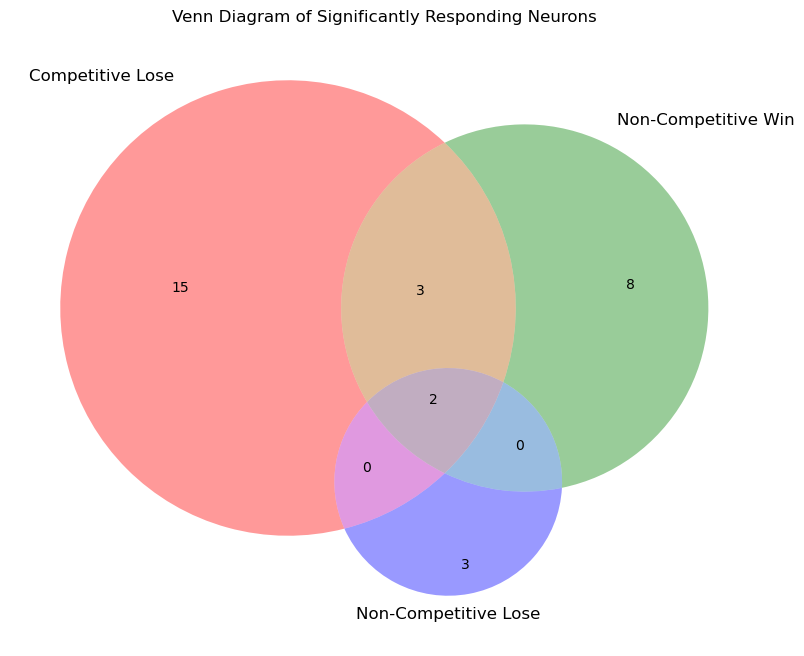

In [49]:
from matplotlib_venn import venn3

# Parsing the events into sets
competitive_lose = set()
no_comp_win = set()
no_comp_lose = set()

# Fill sets with indexes of events
for index, row in sig_units2.iterrows():
    if 'competitive_lose' in row['sig events']:
        competitive_lose.add(index)
    if 'no_comp_win' in row['sig events']:
        no_comp_win.add(index)
    if 'no_comp_lose' in row['sig events']:
        no_comp_lose.add(index)

# Define the venn diagram for the three categories
plt.figure(figsize=(10, 8))
venn_diagram = venn3([competitive_lose, no_comp_win, no_comp_lose], ('Competitive Lose', 'Non-Competitive Win', 'Non-Competitive Lose'))

# Display the Venn diagram
plt.title("Venn Diagram of Significantly Responding Neurons")
plt.show()

In [50]:
sig_units

,Recording,Event name,Unit number,Pre-event M,Pre-event SD,Event M,Event Z-Score,sig,putative type
0,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,5,0.000000,0.000000,0.200000,inf,increase,pyramidal
14,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,58,0.000000,0.000000,0.200000,inf,increase,pyramidal
74,20230612_101430_standard_comp_to_training_D1_s...,no_comp_win,53,0.000000,0.000000,0.020000,inf,increase,pyramidal
89,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,52,0.612500,0.635363,2.362500,2.754332,increase,pyramidal
181,20230612_112630_standard_comp_to_training_D1_s...,no_comp_win,70,0.000000,0.000000,0.066667,inf,increase,pyramidal
208,20230613_105657_standard_comp_to_training_D2_s...,no_comp_lose,300,0.000000,0.000000,0.700000,inf,increase,pyramidal
241,20230613_105657_standard_comp_to_training_D2_s...,competitive_lose,107,0.854545,0.691669,4.309091,4.994504,increase,pyramidal
318,20230614_114041_standard_comp_to_training_D3_s...,competitive_lose,6,3.360000,1.831463,8.300000,2.697297,increase,pyramidal
364,20230614_114041_standard_comp_to_training_D3_s...,no_comp_lose,154,0.000000,0.000000,0.300000,inf,increase,pyramidal
469,20230614_114041_standard_comp_to_training_D3_s...,no_comp_win,175,0.000000,0.000000,0.100000,inf,increase,pyramidal


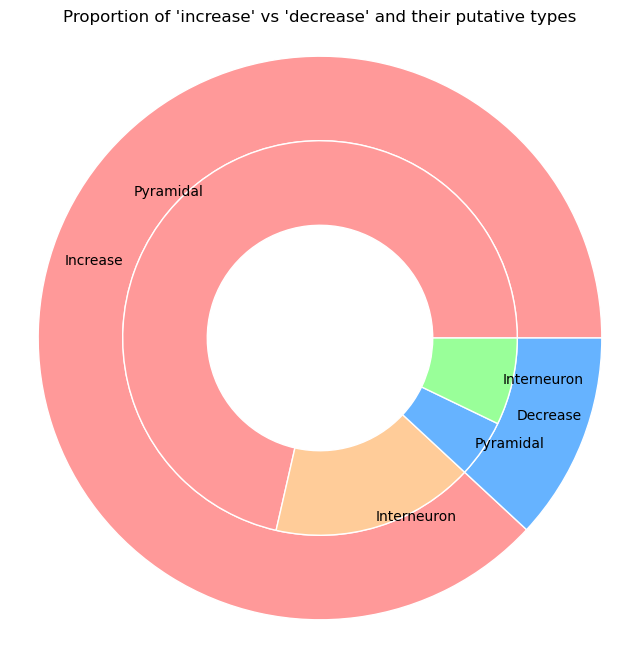

In [51]:
# Calculate the proportions
sig_counts = sig_units['sig'].value_counts()
increase_counts = sig_units[sig_units['sig'] == 'increase']['putative type'].value_counts()
decrease_counts = sig_units[sig_units['sig'] == 'decrease']['putative type'].value_counts()

# Ensure there are no missing categories
increase_counts = increase_counts.reindex(['pyramidal', 'interneuron'], fill_value=0)
decrease_counts = decrease_counts.reindex(['pyramidal', 'interneuron'], fill_value=0)

# Data for the inner and outer pie charts
inner_sizes = [sig_counts['increase'], sig_counts['decrease']]
outer_sizes = [increase_counts['pyramidal'], increase_counts['interneuron'],
               decrease_counts['pyramidal'], decrease_counts['interneuron']]

# Colors
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
inner_colors = ['#ff9999', '#66b3ff']
outer_colors = ['#ff9999', '#ffcc99', '#66b3ff', '#99ff99']

# Plot the pie chart
fig, ax = plt.subplots(figsize=(8, 8))

# Inner pie
ax.pie(inner_sizes, colors=inner_colors, radius=1, labels=['Increase', 'Decrease'],
       labeldistance=0.75, wedgeprops=dict(width=0.3, edgecolor='w'))

# Outer pie
ax.pie(outer_sizes, colors=outer_colors, radius=1-0.3, labels=['Pyramidal', 'Interneuron', 'Pyramidal', 'Interneuron'],
       labeldistance=0.95, wedgeprops=dict(width=0.3, edgecolor='w'))

# Equal aspect ratio ensures that pie is drawn as a circle.
ax.axis('equal')

plt.title("Proportion of 'increase' vs 'decrease' and their putative types")
plt.show()

In [57]:
total_inc_dec_count = sig_units['sig'].value_counts()

In [62]:
total_putative_count = sig_units['putative type'].value_counts()

In [54]:
sig_units_increase = sig_units[sig_units['sig'] == 'increase']

In [60]:
total_inc_count = total_inc_dec_count['increase']

In [61]:
total_dec_count = total_inc_dec_count['decrease']

In [63]:
total_pyr_count = total_putative_count['pyramidal']

In [64]:
total_inter_count = total_putative_count['interneuron']

In [65]:
incr_type_count = sig_units_increase['putative type'].value_counts()

In [67]:
incr_pyr_count = incr_type_count['pyramidal']

In [68]:
incr_inter_count = incr_type_count['interneuron']

In [69]:
sig_units_decrease = sig_units[sig_units['sig'] == 'decrease']

In [70]:
decr_type_count = sig_units_decrease['putative type'].value_counts()

In [71]:
decr_pyr_count = decr_type_count['pyramidal']

In [72]:
decr_inter_count = decr_type_count['interneuron']

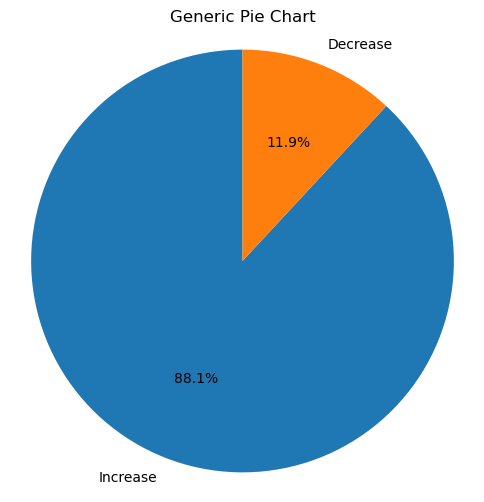

In [73]:
# Example data
data_points = [total_inc_count, total_dec_count]
labels = ['Increase', 'Decrease']

# Plot the pie chart
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(data_points, labels=labels, autopct='%1.1f%%', startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle.
ax.axis('equal')

plt.title("Generic Pie Chart")
plt.show()

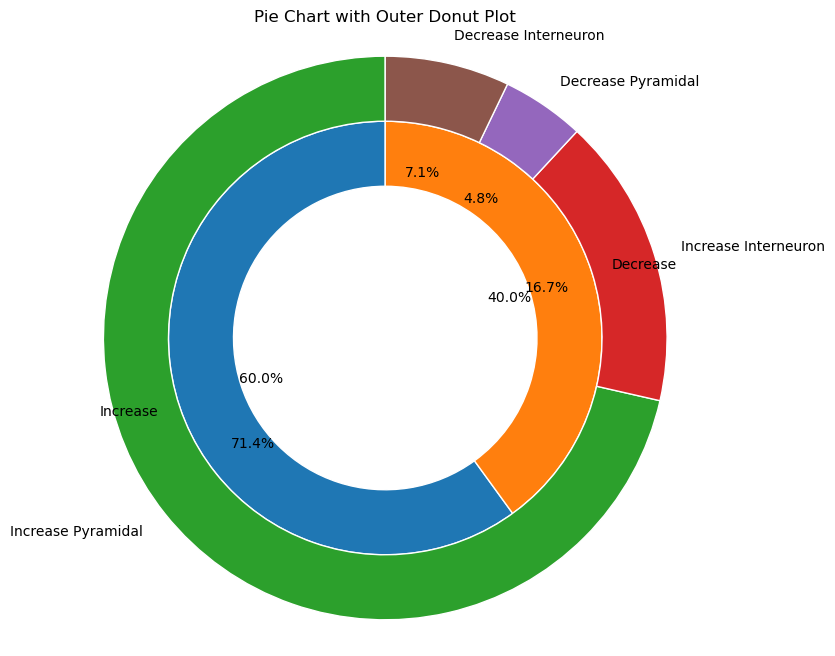

In [81]:
# Example data for inner pie chart
data_points = [total_inc_count, total_dec_count]
inner_labels = ['Increase', 'Decrease']

# Example data for outer donut plot
outer_data_points = [incr_pyr_count, incr_inter_count, decr_pyr_count, decr_inter_count]
outer_labels = ['Increase Pyramidal', 'Increase Interneuron', 'Decrease Pyramidal', 'Decrease Interneuron']

# Plot the inner pie chart
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(inner_data_points, labels=inner_labels, autopct='%1.1f%%', startangle=90, radius=1, wedgeprops=dict(width=0.3, edgecolor='w'))

# Plot the outer donut chart
ax.pie(outer_data_points, labels=outer_labels, autopct='%1.1f%%', startangle=90, radius=1.3, wedgeprops=dict(width=0.3, edgecolor='w'))

# Equal aspect ratio ensures that pie is drawn as a circle.
ax.axis('equal')

plt.title("Pie Chart with Outer Donut Plot")
plt.show()

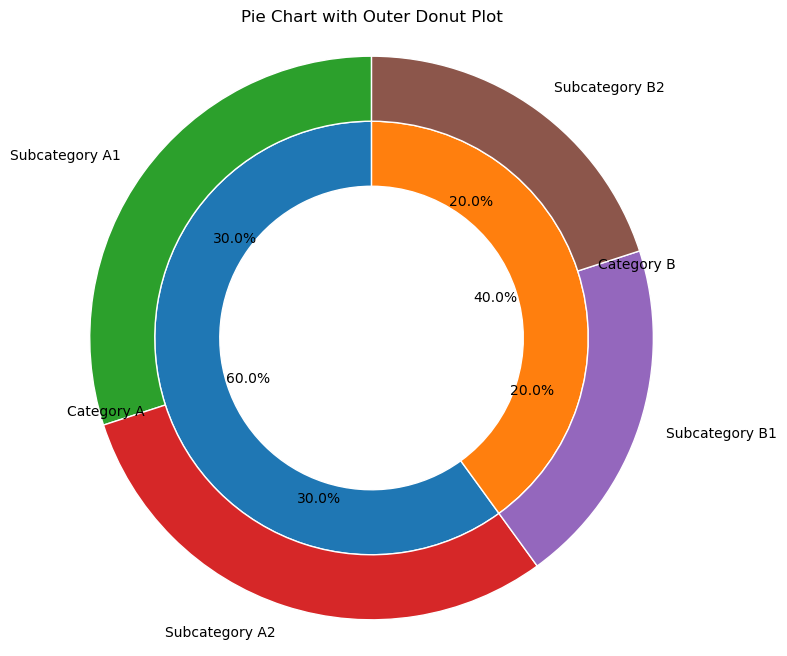

In [79]:
import matplotlib.pyplot as plt

# Example data for inner pie chart
inner_data_points = [60, 40]
inner_labels = ['Category A', 'Category B']

# Example data for outer donut plot
outer_data_points = [30, 30, 20, 20]
outer_labels = ['Subcategory A1', 'Subcategory A2', 'Subcategory B1', 'Subcategory B2']

# Plot the inner pie chart
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(inner_data_points, labels=inner_labels, autopct='%1.1f%%', startangle=90, radius=1, wedgeprops=dict(width=0.3, edgecolor='w'))

# Plot the outer donut chart
ax.pie(outer_data_points, labels=outer_labels, autopct='%1.1f%%', startangle=90, radius=1.3, wedgeprops=dict(width=0.3, edgecolor='w'))

# Equal aspect ratio ensures that pie is drawn as a circle.
ax.axis('equal')

plt.title("Pie Chart with Outer Donut Plot")
plt.show()

In [82]:
total_inc_count

np.int64(37)

In [83]:
total_dec_count

np.int64(5)

In [84]:
incr_pyr_count

np.int64(30)

In [85]:
incr_inter_count

np.int64(7)

In [86]:
decr_pyr_count

np.int64(2)

In [87]:
decr_inter_count

np.int64(3)